In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build dataset
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    block_size = 3  # context length: how many characters do we take to predict the next one?
    X,Y = [], []

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden),generator=g) * (5/3) / ((n_embed*block_size)**0.5)#* 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_runing = torch.zeros((1,n_hidden))
bnstd_runing = torch.ones((1,n_hidden))

parameters =[C, W1,b1,W2,b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix],Ytr[ix]

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    # Linear Layer 
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm Layer 
    # ---------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi =  hpreact.std(0, keepdim=True)
    hpreact = bngain *((hpreact - bnmeani) / bnstdi )+bnbias
    with torch.no_grad():
        bnmean_runing = 0.999 * bnmean_runing + 0.001 * bnmeani
        bnstd_runing = 0.999 * bnstd_runing + 0.001 * bnstdi
    # -----------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    lr = 0.1 if i<100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    # break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


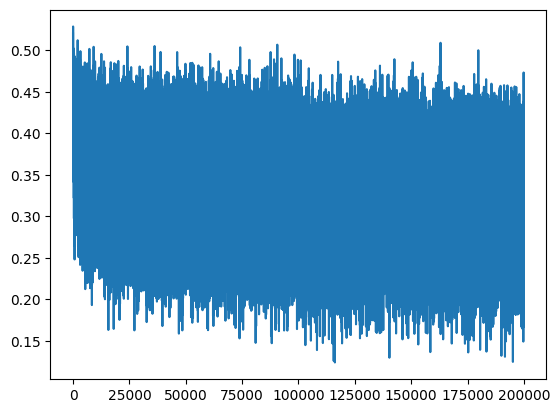

In [10]:
plt.plot(lossi)

In [8]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr] # (N,block_size,n_embd)
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation    
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

In [9]:
@torch.no_grad
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte),
    }[split]
    emb = C[x] # (N,block_size,n_embd)
    embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # hpreact = bngain *((hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True))+bnbias
    hpreact = bngain *((hpreact - bnmean) / bnstd)+bnbias
    h = torch.tanh(hpreact) # hidden layer 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.1049270629882812


In [ ]:
# log
# origin
train 2.069589138031006
val 2.131074905395508

# fix tanh layer
train 2.0357086658477783
val 2.1029491424560547

# kaming init
train 2.0376641750335693
val 2.106989622116089

# add bn
train 2.0668270587921143
val 2.104844808578491

# use bnmean,bnstd from training set
train 2.0668270587921143
val 2.1049270629882812

In [30]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0]*block_size # initializ with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h@ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
ndyn.
alerethruthadrie.
cadelyn.
elin.
shi.
jen.
eden.
est.
aarvelyzion.
kamin.
shub.
roshimies.
kin.
renlynn.
novana.
ubeen.
der.


In [ ]:
# SUMMARY + PYTORCHIFYING -----------

In [13]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

from typing import Any


class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.trining = True
        # parameters (trained with backprob)
        self.gama = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (training with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward
        if self.trining:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch std
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gama * xhat + self.beta

        # update the  buffers
        if self.trining:
            with torch.no_grad():
                self.running_mean =(1 - self.momentum) * self.running_mean +  self.momentum * xmean      
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gama, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out =  torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
     # last layer: make less confident
     layers[-1].weight *= 0.1
     # all other layers: aplly gain
     for layer in layers[:-1]:
         if isinstance(layer, Linear):
             layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True    

46497


In [14]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix],Ytr[ix]

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0],-1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update 
    lr = 0.1 if i<100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    break # AFTER_DEBUG: would take out obvious to run full optimization

AttributeError: 'Tensor' object has no attribute 'return_grad'